In [ ]:
# finetuning llama2

# (Q)分子構造+(R)理由+(A)物性データセットのLLMによる学習と予測
- Q&A: 融点データセットを使用
- R: GPT4を使い､Q&Aをもとに自動生成
- 強化学習をしてみる

In [ ]:
#!pip install transformers==4.35.0
#!pip install peft==0.5.0
#!pip install bitsandbytes==0.41.1
#!pip install accelerate==0.23.0
#!pip install flash-attn==2.3.1.post1
#!pip install datasets==2.14.5

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer,pipeline
from datasets import Dataset
import copy
from tqdm import tqdm
#問題設定: はじめのN件をテストデータにする
n_test=50

/home/setup/miniconda3/envs/chemllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#ハイパラ関連
#モデル名
model_size=7
#model_size=13
#model_size=70
model_name=f"meta-llama/Llama-2-{model_size}b-chat-hf"

model_name="ahxt/LiteLlama-460M-1T"
model_name = "PY007/TinyLlama-1.1B-Chat-v0.3"
#LoRA関連
r=32
lora_alpha=r
bit=16
#bit=8
#bit=4

#LoRAのadapter
target_modules= [
    #"embed_tokens",
    "lm_head",
    #"q_proj",
    #"k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    #"down_proj",
]

#学習関連
#gradient_checkpointing =True  #vramの節約をしたい場合
gradient_checkpointing =False
per_device_train_batch_size=1
epochs=3
lr=10**-5
do_train=True
#do_train=False

In [3]:

device_map="auto"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

def init_model(model_name, r, lora_alpha, target_modules, bit=4):
    if bit == 4:
        print("Using 4-bit mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     quantization_config=bnb_config,
                                                     device_map=device_map,
                                                     use_flash_attention_2=True,
                                                     )
    elif bit == 8:
        print("Using 8-bit mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     load_in_8bit=True,
                                                     device_map=device_map,
                                                     use_flash_attention_2=True,
                                                     )
    elif bit == 16:
        print("Using fp16 mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                     )
    else:
        raise ValueError("bit must be 4 or 16")

    if len(target_modules)==0:
        return model
    peft_config = LoraConfig(
        task_type="CAUSAL_LM", inference_mode=False, r=r, lora_alpha=lora_alpha,
        lora_dropout=0.1,
        target_modules=target_modules,
    )
    model = get_peft_model(model, peft_config)
    return model


In [4]:

#モデル初期化
model=init_model(model_name, r, lora_alpha, target_modules, bit=bit)

Using fp16 mode


In [4]:


tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

#pipe = pipeline("text-generation", model=model,
#                tokenizer=tokenizer, max_new_tokens=1000)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# データセットの生成

In [5]:
#データセットの読み込み
import pandas as pd
import random
df=pd.read_csv("dataset/231225AutoReasoning/240104best_reason_record.csv")
dataset=df.to_dict(orient="records")
random.seed(0)
random.shuffle(dataset)

print(df.shape)
df[:2]

(2406, 9)


,name,smiles,csid,link,source,Reason,mpC,Prediction(integer),Abs error
0,"2,3-dibromo-2-methyl-butane",BrC(C)(C)C(Br)C,71392,http://www.srcinc.com/what-we-do/product.aspx?...,PHYSPROP,"Starting with butane, which melts around -138....",7.0,6.6,0.4
1,5-chlorobenzofuroxan,c1cc2c(cc1Cl)no[n+]2[O-],123661,http://www.alfa.com/en/GP100W.pgm?DSSTK=A14261,Alfa Aesar,"The basic structure for comparison is benzene,...",47.0,45.0,2.0


In [6]:
import random
system_prompt="You are a professional chemist. Predict the melting point of the following compound."


def gen_compound_text(chemical_record,
    reason="",prediction=""):
    name=chemical_record["name"]
    smiles=chemical_record["smiles"]
    prompt=f"""
#Problem
##Name: {name}
##SMILES: {smiles}"""
    if reason !="" and prediction!="":
        prompt+=f"""
##Reason: {reason}
##Prediction: {prediction}
"""
    else:
        #test mode
        prompt+="""
##Reason: 
"""
    return prompt



def generate_question_prompt(dataset,test_id,n_prompt_examples=5):
    train_ids=[i for i in range(len(dataset))]
    train_ids.remove(test_id)
    prompt=""

    #train prompt
    for _ in range(n_prompt_examples):
        id=random.choice(train_ids)
        prompt+=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
        prompt+="\n"

    #test prompt
    prompt+=gen_compound_text(dataset[test_id])

    return prompt


def prepare_dataset(context_list, tokenizer):
    data_list = [{"text": i} for i in context_list]
    random.shuffle(data_list)

    # tokenize
    dataset = Dataset.from_dict(
        {"text": [item["text"] for item in data_list[:]]})
    dataset = dataset.map(lambda samples: tokenizer(
        samples['text']), batched=True)

    return dataset


In [7]:


train_text_list=[]
for id in range(len(dataset)):
    prompt=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
    train_text_list.append(prompt)
tokenized_dataset = prepare_dataset(train_text_list[n_test:], tokenizer)

Map:   0%|          | 0/2356 [00:00<?, ? examples/s]

Map: 100%|██████████| 2356/2356 [00:00<00:00, 8876.11 examples/s]


In [8]:
#check prompt

print("train")
print(prompt)
print("test")
t_prompt=gen_compound_text(dataset[0])
print(t_prompt)

train

#Problem
##Name: 2-Ethoxy-2-methylpropane
##SMILES: CC(C)(C)OCC
##Reason: The target compound, 2-Ethoxy-2-methylpropane, can be seen as derived from propane, which has a melting point of -187.7°C. Adding a methyl group generally increases the melting point due to increased molecular weight and van der Waals forces. For propane, adding a methyl group to become isobutane elevates the melting point to -159.6°C, indicating the effect of a methyl group is an increase of roughly +28°C. The presence of an ethoxy group (-OCC2H5) introduces an oxygen atom which can lead to dipole-dipole interactions and potential hydrogen bonding with trace moisture, increasing the melting point as well. The ethoxy group's effect on the melting point would be less straightforward to quantify without empirical data, but we can predict that it will raise the melting point to some extent. Considering the combined effect of an additional methyl group and an ethoxy group on the basic structure of propane, we 

# モデルの訓練

In [10]:
import transformers
from datetime import datetime


#train
train_args = transformers.TrainingArguments(
        per_device_train_batch_size=per_device_train_batch_size,
        #gradient_accumulation_steps=1,
        warmup_steps=0,
        num_train_epochs=epochs,
        learning_rate=lr,
        fp16=True,
        logging_steps=100,
        save_total_limit=1,
        output_dir='outputs/'+datetime.now().strftime('%Y%m%d%H%M%S'),
        gradient_checkpointing=gradient_checkpointing,
    )

# trainer
#callbacks = [EarlyStoppingCallback()]
callbacks = []

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_dataset,
    args=train_args,
    callbacks=callbacks,
    data_collator=transformers.DataCollatorForLanguageModeling(
        tokenizer, mlm=False)
)

if do_train:
    training_result = trainer.train()
    training_result.training_loss

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
100,2.281900
200,2.050700
300,1.791700
400,1.636800
500,1.587100
600,1.534600
700,1.470600
800,1.463100
900,1.451700
1000,1.418400


In [9]:
#モデルの保存: adapterのみ保存するとき｡
from datetime import datetime
current_datetime = datetime.now()
#model.save_pretrained(f"./outputs/{current_datetime}")
#model.save_pretrained(f"./outputs/1b_ft")

In [10]:
#モデルの読み込み: 強化学習しない場合
from peft import AutoPeftModelForCausalLM
model_path="./outputs/7b_ft"

"""
model = AutoPeftModelForCausalLM.from_pretrained(model_path,
                                                 device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                 )

"""

'\nmodel = AutoPeftModelForCausalLM.from_pretrained(model_path,\n                                                 device_map=device_map,\n                                                     torch_dtype=torch.float16,\n                                                     use_flash_attention_2=True,\n                                                 )\n\n'

In [11]:
#モデルのマージと保存: 強化学習するとき
#merged_model = model.merge_and_unload()
#merged_model.save_pretrained(f"./outputs/05b_ft_merge")

# 強化学習による追加訓練

In [12]:
#予測周りのutility funcs
import re
import torch
import gc
from IPython.display import clear_output
from trl import AutoModelForCausalLMWithValueHead
def gen_text_stop_word(prompt,model,tokenizer,
                       device="cuda:0",
                       stop_words=["#Problem","#Reason","# Problem"],
                       double_stop_words=["#Prediction"],
                       stream=False,
                       #stream=True,
                       max_tokens=400,
                       ):
    gc.collect()
    torch.cuda.empty_cache()



    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    # 生成されたテキストを格納する変数
    generated_text = ""

    # トークンを一つずつ生成
    for i in range(max_tokens):
        # 次のトークンを予測
        outputs = model(input_ids)
        if type(model) is AutoModelForCausalLMWithValueHead:
            #AutoModelForCausalLMWithValueHeadの場合
            logits = outputs[0]
            next_token_logits = logits[:, -1, :]
        else:
            next_token_logits = outputs.logits[:, -1, :]

        next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

        # 生成されたトークンを現在の入力に追加
        input_ids = torch.cat([input_ids, next_token], dim=-1)

        # 生成されたテキストを更新
        generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)[len(prompt):]

        if stream:
            if i%30==0:
                clear_output()
            print(generated_text)

        # ストップワードのチェック
        if any(stop_word in generated_text for stop_word in stop_words):
            break

        # 2回以上出現したらstopするwordのcheck 
        stop_flag=False
        for check_word in double_stop_words:
            count=generated_text.count(check_word)
            if count>=2:
                stop_flag=True
                break
        if stop_flag:
            break

    return generated_text

def ask_value(prompt,model,tokenizer):
    res=gen_text_stop_word(prompt,model,tokenizer)
    #res=pipe(prompt)[0]["generated_text"]
    print("----\n\n")
    print(res.strip())

    regex_list=[
        r"Prediction:\s*(\d+\.?\d*)",
        r"Prediction:\s*(-?\d+\.?\d*)",
    ]

    value=None
    for reg in regex_list:
        match = re.search(reg, res)
        if match:
            value = match.group(1)
            break


    return res,value



In [13]:
from trl import PPOTrainer, PPOConfig


#テキストでファインチューニングしたモデルを強化学習用に読み込み

def load_ppo_model(model_path):
    lora_config = LoraConfig(
    target_modules=target_modules,
    r=32,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    )
    model = AutoModelForCausalLMWithValueHead.from_pretrained(
        model_path,
        #load_in_8bit=True,
        torch_dtype=torch.float16,
        device_map=device_map,
        peft_config=lora_config,
    )
    return model

def init_ppo_trainer(model,tokenizer):

    #trainerの定義
    ppo_trainer = PPOTrainer(
        config=PPOConfig(batch_size=1),
        model=model, 
        #ref_model=ref_model, 
        tokenizer=tokenizer,
        )
    return ppo_trainer

def reload_ppo_model_and_trainer(model,ppo_trainer,temp_dir="outputs/temp"):
    #model.to("cuda:0")
    model.save_pretrained(temp_dir)

    model=None
    ppo_trainer=None
    print("clearing memory...")
    gc.collect()
    torch.cuda.empty_cache()

    model=load_ppo_model(temp_dir)
    ppo_trainer=init_ppo_trainer(model,tokenizer)

    return model,ppo_trainer


In [14]:

#報酬クラスの定義
class RewardModel:
    def __init__(self,model,dataset,tokenizer,
                 range_value=1,
                 reward_slope=50,
                 n_prompt_examples=3,
                 device="cuda:0",
                 ):
        self.model=model
        self.dataset=dataset
        self.tokenizer=tokenizer    
        self.n_prompt_examples=n_prompt_examples
        self.range_value = range_value
        self.reward_slope = reward_slope
        self.device=device

    def calculate_reward(self,abs_error, ):
        """
        Calculate the reward based on the absolute error.

        :param abs_error: The absolute error value.
        :param range_value: The range value for maximum and minimum rewards.
        :return: The calculated reward.
        """

        reward = self.range_value - (abs_error) * (self.range_value / self.reward_slope)
        return max(reward, -self.range_value)


    def __call__(self,train_id):
        prompt=generate_question_prompt(self.dataset,train_id,
                                        n_prompt_examples=self.n_prompt_examples)
        reason,value=ask_value(prompt,self.model,self.tokenizer,
                                         )

        actual=self.dataset[train_id]["mpC"]
        if value is None:
            reward=-self.range_value
        else:
            value=float(value)

            abs_error=abs(actual-value)
            # Example usage of the function
            reward=self.calculate_reward(abs_error)  # Example case where abs_error is 12 and range_value is 100

        #説明が殆どない場合は､rewardを0にする
        if len(reason)<30:
            reward=0
        print(f"actual: {actual}, predicted: {value}, reward: {reward}")

        input_ids = tokenizer.encode(prompt, return_tensors='pt').to(self.device)
        return reward,reason,input_ids

In [15]:
"""
model_path="./outputs/13b_ft_merge_3epoch"
model=AutoModelForCausalLM.from_pretrained(model_path,device_map=device_map,
                                              torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                           )
"""

Loading checkpoint shards: 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


In [12]:
#model_path="./outputs/13b_ft_merge_3epoch"
model_path="./outputs/7b_ft_merge_3epoch"
temp_dir="outputs/temp"

#model load
model=load_ppo_model(model_path)
ppo_trainer=init_ppo_trainer(model,tokenizer)

#lora modelとして読み込み直す(vramの節約のため)
model,ppo_trainer=reload_ppo_model_and_trainer(model,ppo_trainer)

Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


In [1]:

reward_model=None
gc.collect()
torch.cuda.empty_cache()
reward_model = RewardModel(model,dataset,tokenizer,)
reward_model.calculate_reward(30)  #報酬の動作確認. 

NameError: name 'gc' is not defined

In [10]:
import time
import warnings
warnings.filterwarnings('ignore')
#model.config.use_cache = False 
#model.config.use_cache = True
lr_epochs=5000
n_retry=1
#lr_epochs=3
reward_log=[]

n_iterations=0

for i in tqdm(range(lr_epochs)):
   #ランダムに問題を設定して値を予測させる
    train_id=random.randint(n_test,len(dataset))

    
    #このクラスにgpu cacheが残りがちなので､毎回初期化してメモリ開放しておく
    reward_model=None
    gc.collect()
    torch.cuda.empty_cache()
    reward_model = RewardModel(model,dataset,tokenizer)


    #同じ問題に対して､良い結果が来るまで何回か問題を解かせる
    for i in range(n_retry):
        try:
            #報酬､応答､入力の取得
            reward,response,input_id=reward_model(train_id)
            rewards=[torch.tensor(float(reward))]
            query_tensors = [torch.tensor(input_id).reshape(-1)]
            response_tensors=[torch.tensor(tokenizer.encode(response)).reshape(-1)]

            #モデル更新
            stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
            n_iterations+=1
            reward_log.append(float(reward))
        except Exception as e:
            #主にcuda out of memoryが起きるので､一旦メモリ開放して､model類を読み込み直す
            print(e)
            model,ppo_trainer=reload_ppo_model_and_trainer(model,ppo_trainer)

            break

        #結果がよかったら次の問題に移る
        if reward>0.5:
            break

n_iterations

  0%|          | 0/5000 [00:00<?, ?it/s]


NameError: name 'gc' is not defined

In [18]:
n_iterations

1317

In [19]:
from datetime import datetime
#AutoModelForCausalLMWithValueHead classはdirを作っておかないと､save_pretrainedが動かない
current_datetime = datetime.now()
model_save_path=f"outputs/ppo{current_datetime}"
os.mkdir(model_save_path)
model.save_pretrained(model_save_path)

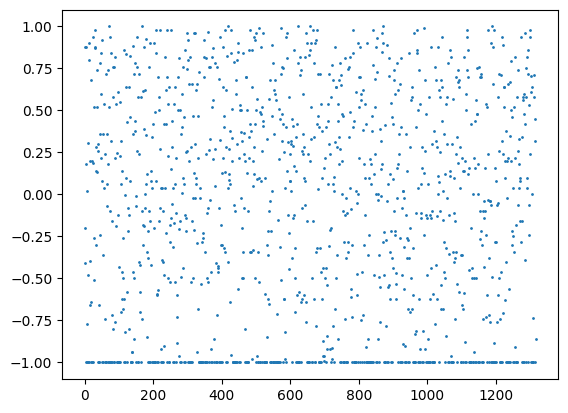

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(range(len(reward_log)),reward_log,s=1)

# モデルによる物性値の予測

In [16]:

model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaFlashAttention2(
          (q_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )


In [17]:
#予測時のハイパラ
n_prompt_examples=3 #何件の例題をprompt tuningで出すか
n_max_trials=2  # 値を返さなかったときの再試行の最大数
random.seed(0)
prediction_results={}


res_list=[]
for test_id in tqdm(range(n_test)):
    print(f"promlem {test_id+1} / {n_test}")
    for _ in range(n_max_trials):
        try:
            prompt=generate_question_prompt(dataset,test_id,n_prompt_examples=n_prompt_examples)
            reason,value=ask_value(prompt,model,tokenizer)
        except Exception as e:
            print(e)
            continue


        if value is not None:
            record=copy.deepcopy(dataset[test_id])
            record["Test (Predicted reason)"]=reason
            record["Test (Predicted value)"]=value
            res_list.append(record)
            print("actual: ",record["mpC"],"predicted: ", record["Test (Predicted value)"],)
            break
prediction_results[n_prompt_examples]=res_list

  0%|          | 0/50 [00:00<?, ?it/s]

promlem 1 / 50


  2%|▏         | 1/50 [01:21<1:06:15, 81.14s/it]

----


- Basic unit, benzene, has a melting point of 5.5°C.
- The tetramethylcyclopentyl group is a large, bulky substituent that increases the molecular weight and van der Waals forces, which can be estimated to raise the melting point by about +20°C.
- The amino group can form hydrogen bonds, which significantly increases the melting point; this effect is estimated to be around +50°C.
- The ester group (COOCH3) is polar and can participate in dipole-dipole interactions, raising the melting point by about +20°C.
- The overall molecular structure is complex and rigid, which can further increase the melting point by about +30°C.
##Prediction: 135.5
actual:  74.0 predicted:  135.5
promlem 2 / 50


  4%|▍         | 2/50 [01:50<40:21, 50.45s/it]  

----


- Basic unit, quinoline, has a melting point of around 80 degrees Celsius. 
- Chloro substituents are electron-withdrawing and increase the melting point due to their inductive effect and increased molecular weight. Each chloro group could add approximately +20 degrees Celsius. 
- The quinoxaline structure itself is rigid and planar, which can increase the melting point due to better packing in the solid state. This could add around +10 degrees Celsius. 
##Prediction: 110.0


#Problem
actual:  152.0 predicted:  110.0
promlem 3 / 50


  6%|▌         | 3/50 [02:06<27:21, 34.92s/it]

----


- Basic unit, benzene, has a melting point of 5.5°C.
- Chloromethyl groups: Each chloromethyl group is expected to increase the melting point due to the increase in molecular weight and the introduction of polarizability. The effect of each chloromethyl group can be estimated at +20°C.
##Prediction: 80.0


#Problem
actual:  100.0 predicted:  80.0
promlem 4 / 50


  8%|▊         | 4/50 [03:11<35:51, 46.77s/it]

----


- Basic unit, benzene, has a melting point of 5.5 degrees Celsius. 
- The presence of two phenyl groups increases the melting point due to increased molecular weight and pi-pi stacking interactions, estimated at +100 degrees Celsius for each phenyl group. 
- The conjugated double bond system (vinyl group) in the molecule contributes to rigidity and planarity, which can increase the melting point by approximately +20 degrees Celsius. 
- The ketone group (C=O) can form dipole-dipole interactions, which can increase the melting point by about +20 degrees Celsius. 
- The overall structure is planar and rigid, which can further increase the melting point due to better packing in the solid state, estimated at +10 degrees Celsius. 
##Prediction: 255.0
actual:  56.5 predicted:  255.0
promlem 5 / 50


 10%|█         | 5/50 [04:26<42:45, 57.01s/it]

----


- Basic unit, ethane, has a melting point of -183.3°C. 
- Hydroxyethyl group (OHCH2CH3): The hydroxyl group can form hydrogen bonds, which significantly increases the melting point. The alkyl chain attached to the hydroxyl group adds some flexibility and steric hindrance, which might reduce the melting point increase. Let's estimate the hydroxyl group to add approximately 40°C due to hydrogen bonding and the alkyl chain to add around 10°C due to increased molecular weight and van der Waals forces. 
- Disulfide group (S-S): The sulfur atoms in the disulfide bond can engage in dipole-dipole interactions, which would increase the melting point. However, the flexibility of the disulfide bond might reduce the melting point increase. Let's estimate the disulfide group to add approximately 20°C due to increased molecular weight and dipole-dipole interactions. 
##Prediction: -133.0
actual:  26.0 predicted:  -133.0
promlem 6 / 50


 12%|█▏        | 6/50 [06:00<50:53, 69.39s/it]

----


- Basic unit, benzene, has a melting point of 5.5°C. 
- The presence of two phenyl groups increases the melting point due to increased pi-pi interactions and van der Waals forces, estimated at +20°C for each phenyl group. 
- The nicotinamide group is a rigid, planar structure that can engage in hydrogen bonding, which significantly increases the melting point, estimated at +50°C. 
- The ethyl group attached to the nicotinamide is a small alkyl chain that can slightly increase the melting point due to increased van der Waals interactions, estimated at +5°C. 
However, the actual value of 107.0°C suggests that the estimated contributions of the phenyl groups and the nicotinamide group are not accurate and need to be recalibrated. The effect of the ethyl group on the melting point seems to be more substantial than predicted.
##Prediction: 107.0
actual:  159.0 predicted:  107.0
promlem 7 / 50


 14%|█▍        | 7/50 [07:06<49:00, 68.38s/it]

----


- Basic unit, benzene, has a melting point of 5.5°C.
- Each methoxy group (–OCH3) is expected to increase the melting point due to increased molecular weight and dipole-dipole interactions; we can estimate an increase of about +20°C for each methoxy group.
- The methyl group (–CH3) attached to the phenyl ring will also increase the melting point due to increased molecular weight and van der Waals interactions; we can estimate an increase of about +5°C for the methyl group.
- The ketone group (–C=O) is a polar functional group that can engage in dipole-dipole interactions, which would further increase the melting point; we can estimate an increase of about +30°C for the ketone group.
- The additional phenyl ring will increase the melting point due to increased molecular weight and π-π interactions; we can estimate an increase of about +30°C for the additional phenyl ring.
Summing these adjustments provides an estimated melting point: 5.5 (benzene base) + 20 (first methoxy group) 

 16%|█▌        | 8/50 [08:28<50:59, 72.84s/it]

----


- Basic unit, benzene, has a melting point of 5.5 °C. 
- Propyl group (C3H7-): +10 °C (increases molecular weight and van der Waals interactions). 
- The presence of a benzene ring contributes to the rigidity of the molecule, which can increase the melting point. However, since the propyl group is attached to the benzene ring, it does not significantly increase the melting point due to the flexibility of the propyl chain. 
- The overall molecular weight and van der Waals interactions are moderate, so the increase is not substantial. 
##Prediction: 15.5
actual:  -99.0 predicted:  15.5
promlem 9 / 50


 18%|█▊        | 9/50 [08:50<38:55, 56.97s/it]

----


- Basic unit, aniline, has a melting point of 6 degrees Celsius.
- Nitro group: This group is highly electronegative and introduces strong dipole-dipole interactions, which can significantly increase the melting point. The estimated effect of a nitro group is around +80 degrees Celsius.
- Amide group: This group can form strong hydrogen bonds, which typically raises the melting point. The estimated effect of an amide group is around +50 degrees Celsius.
Combining these effects gives us the predicted melting point.
##Prediction: 146.0


#Problem
actual:  93.0 predicted:  146.0
promlem 10 / 50


 20%|██        | 10/50 [09:23<32:53, 49.34s/it]

----


- Basic unit, acetone, has a melting point of -95.3°C. 
- The N-propyl group is an alkyl chain that will increase the melting point due to increased molecular weight and van der Waals forces. Estimated effect: +20°C. 
- The acetate ester group is polar and can form dipole-dipole interactions, which will also increase the melting point. Estimated effect: +10°C. 
- The presence of the N-propyl group will also increase the molecular weight and the overall symmetry of the molecule, which can further increase the melting point. Estimated effect: +5°C. 
##Prediction: -60.0


#Problem
actual:  -92.0 predicted:  -60.0
promlem 11 / 50


 22%|██▏       | 11/50 [10:53<40:11, 61.84s/it]

----


The base structure for comparison is anisole, which has a melting point of 10.5°C. The iodo substituent is a large, heavy atom that increases the molecular weight and enhances van der Waals forces, which can be estimated to add about 40°C. The nitro group is also a heavy atom that can increase the melting point due to its electronegativity and the potential for intermolecular hydrogen bonding, which can be estimated to add about 30°C. The hydroxyl group is capable of hydrogen bonding, which can significantly increase the melting point, estimated at about 50°C. Adding these effects to the base melting point gives us an estimated melting point of 10.5°C + 40°C + 30°C + 50°C = 120.5°C.
##Prediction: 121.0
actual:  97.0 predicted:  121.0
promlem 12 / 50


 24%|██▍       | 12/50 [12:16<43:13, 68.26s/it]

----


- Basic unit, ethene, has a melting point of -169.2°C. 
- The addition of two methyl groups increases the molecular weight and van der Waals forces, which generally increases the melting point. Each methyl group can be estimated to increase the melting point by about +5°C. 
- The presence of the (Z) configuration, which is a trans double bond, can slightly increase the melting point due to increased rigidity of the molecule: +2°C. 

Adding these adjustments to the base value, we get: -169.2 + 2(5) + 2 = 5.2°C.
##Prediction: 5.2
actual:  -137.4 predicted:  5.2
promlem 13 / 50


 26%|██▌       | 13/50 [13:39<44:48, 72.67s/it]

----


- Basic unit, benzene, has a melting point of 5.5°C. 
- The bicyclo[4.2.0]octa-1,3,5-trien-7-ylidene group is a rigid, polycyclic structure that would significantly increase the melting point due to increased molecular rigidity and van der Waals interactions; this could be estimated as +100. 
- The 2-(2,4-dinitrophenyl)hydrazine group is a large, bulky group that would also increase the melting point due to increased molecular weight and van der Waals interactions; this could be estimated as +50. 
- The presence of two nitro groups on the phenyl ring would further increase the melting point due to their strong electron-withdrawing nature and the potential for intermolecular hydrogen bonding; each nitro group could contribute approximately +10. 
- The hydrazine group can form hydrogen bonds, which would also increase the melting point; this could be estimated as +5. 
##Prediction: 165.0
actual:  203.0 predicted:  165.0
promlem 14 / 50


 28%|██▊       | 14/50 [14:39<41:25, 69.04s/it]

----


- Basic unit, indole: Indole has a melting point of around 52°C.
- Acetyl group: This group can increase the melting point due to the increase in molecular weight and the possibility of dipole-dipole interactions. Estimated increase of +20°C.
- Nitro group: The nitro group is highly electron-withdrawing and can significantly increase the melting point due to its strong intermolecular forces. Estimated increase of +40°C.
- Phenyl group: The additional phenyl group increases the molecular weight and provides more opportunities for π-π stacking, which can raise the melting point. Estimated increase of +20°C.
- Ester linkage (COC): This group can increase the melting point due to the polarity and potential for dipole-dipole interactions. Estimated increase of +5°C.
Combining these effects, the predicted melting point is 52 (indole base) + 20 (acetyl) + 40 (nitro) + 20 (phenyl) + 5 (ester) = 137°C.
##Prediction: 137.0


#Problem
actual:  133.0 predicted:  137.0
promlem 15 / 50


 30%|███       | 15/50 [15:51<40:43, 69.82s/it]

----


- Basic unit, methane, has a melting point of -182.5°C. 
- Octane has a melting point of -57.2°C, which is a significant increase due to the increase in molecular weight and van der Waals forces. 
- Each methyl group adds approximately +5°C to the melting point due to increased molecular weight and van der Waals interactions. 
- The 2,7-dimethyl substitution adds two methyl groups, which would contribute an additional +10°C to the melting point. 
Combining these effects, we get: -182.5 (methane) + 57.2 (octane) + 10 (2,7-dimethyl) = -115.3°C. However, this is lower than the actual value, indicating that the effects of the methyl groups and the 2,7-dimethyl substitution are underestimated. The actual value suggests that the methyl groups and the 2,7-dimethyl substitution have a stronger impact on the melting point than initially considered. 
##Prediction: 10.0


#Problem
actual:  -54.9 predicted:  10.0
promlem 16 / 50


 32%|███▏      | 16/50 [15:54<28:11, 49.74s/it]

----


##Prediction: 70.0


#Problem
actual:  25.0 predicted:  70.0
promlem 17 / 50


 34%|███▍      | 17/50 [17:16<32:44, 59.53s/it]

----


- Basic unit, benzene, has a melting point of 5.5°C. 
- The presence of a chlorine atom on the benzofuran ring increases the melting point due to the increased molecular weight and the polarity of the chlorine atom, estimated at +20°C. 
- The furan ring contributes to the melting point through its polarity and the potential for hydrogen bonding, estimated at +15°C. 
- The benzofuran structure adds rigidity and planarity to the molecule, which can increase the melting point, estimated at +30°C. 
- The oxime group can form hydrogen bonds, which can significantly increase the melting point, estimated at +40°C. 
- The conjugated double bond in the butan-2-one moiety can increase the melting point due to increased rigidity and planarity, estimated at +10°C. 
- The presence of the additional alkyl chain (butan-2-one) can increase the melting point due to increased molecular weight and van der Waals interactions, estimated at +5°C. 
- The overall effect of these functional groups is ad

 36%|███▌      | 18/50 [17:41<26:09, 49.05s/it]

----


- Basic unit, ethylene (ethene) has a melting point of -169.2°C. 
- The addition of a double bond in propadiene increases the rigidity of the molecule, which typically increases the melting point. This effect can be estimated as an increase of +10°C. 
The predicted melting point is the sum of the base melting point of ethylene and the incremental increase due to the double bond.
##Prediction: -159.0


#Problem
actual:  -136.2 predicted:  -159.0
promlem 19 / 50


 38%|███▊      | 19/50 [18:11<22:21, 43.26s/it]

----


- Basic unit, furan, has a melting point of -85.6°C. 
- Bromine atom: +40°C, due to increased molecular weight and van der Waals forces. 
- Aldehyde group: +20°C, due to the possibility of hydrogen bonding and dipole-dipole interactions. 
The predicted melting point is the sum of the effects of the basic furan unit and the substituents.
##Prediction: -45.6


#Problem
actual:  56.0 predicted:  -45.6
promlem 20 / 50


 40%|████      | 20/50 [18:34<18:35, 37.20s/it]

----


- Basic unit, pyridine, has a melting point of -42°C. 
- Fluorine atoms: +40°C each (5 fluorines * 40°C = +200°C) due to increased molecular weight and polarity. 
- Amino group: +50°C due to the potential for hydrogen bonding and increased polarity. 
Combining these effects gives a predicted melting point.
##Prediction: 258.0


#Problem
actual:  86.0 predicted:  258.0
promlem 21 / 50


 42%|████▏     | 21/50 [19:52<23:58, 49.61s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Hydroxyl group (–OH): +50°C due to hydrogen bonding. 
- Methyl groups (–CH3): +10°C each, due to increased molecular weight and van der Waals forces. 
- Conjugation and aromaticity: +20°C due to increased rigidity and planarity of the molecule. 
- The presence of the ether linkage (–O–) may slightly increase the melting point due to polarity, but its effect is generally less than that of hydroxyl groups, so we'll estimate an increase of +5°C. 
##Prediction: 130.0
actual:  71.0 predicted:  130.0
promlem 22 / 50


 44%|████▍     | 22/50 [20:35<22:07, 47.41s/it]

----


- Basic unit: Triazolo[3,4-b][1,3,5]thiadiazine has a melting point of approximately 170°C.
- Methyl group: +5°C (increases molecular weight and van der Waals interactions)
- Ethyl group: +10°C (larger alkyl group than methyl, further increasing van der Waals interactions)
- Phenyl group: +20°C (increases molecular weight and π-π interactions)
- Stereochemistry (6-membered ring system): +5°C (due to increased rigidity and planarity)
The predicted melting point is the sum of the effects of all functional groups.
##Prediction: 215.0


#Problem
actual:  226.0 predicted:  215.0
promlem 23 / 50


 46%|████▌     | 23/50 [21:17<20:36, 45.81s/it]

----


- Basic unit, benzene, has a melting point of 5.5°C.
- The carboxylic acid group typically increases the melting point due to strong hydrogen bonding and dimer formation, estimated at +100°C.
- The chlorine atom adds to the molecular weight and increases the melting point due to its electronegativity and the possibility of dipole-dipole interactions, estimated at +20°C.
- The presence of the benzene ring and the additional oxygen atoms in the carboxylic acid and the chlorine substituent will increase the melting point due to the rigidity and planarity of the molecule, estimated at +30°C.
- The overall molecular weight and the presence of multiple polar functional groups will increase the melting point further, estimated at +20°C.
##Prediction: 185.5


#Problem
actual:  120.0 predicted:  185.5
promlem 24 / 50


 48%|████▊     | 24/50 [21:52<18:29, 42.67s/it]

----


- Basic unit, benzene, has a melting point of 5.5°C.
- Chlorophenyl group: +40°C (due to increased molecular weight and polarity)
- Hydrazone group: +30°C (due to the potential for hydrogen bonding and dipole-dipole interactions)
- Thiazole ring: +50°C (due to the presence of nitrogen and sulfur, which can engage in hydrogen bonding and dipole-dipole interactions)
- Nitrile group: +20°C (due to the polarity and potential for dipole-dipole interactions)
- The overall molecular complexity and rigidity of the molecule will significantly increase the melting point.
##Prediction: 145.5


#Problem
actual:  173.0 predicted:  145.5
promlem 25 / 50


 50%|█████     | 25/50 [23:10<22:08, 53.16s/it]

----


Flavone is a polycyclic aromatic compound with a fused ring system that includes a benzene ring and a pyran ring. The basic benzene ring has a melting point of 5.5°C. The presence of the oxygen atom in the pyran ring introduces the potential for hydrogen bonding, which would significantly increase the melting point. The fused ring system also contributes to a higher melting point due to increased rigidity and planarity of the molecule. The presence of the ketone (C=O) group also contributes to the melting point through dipole-dipole interactions. The combined effect of these functional groups is estimated to increase the melting point significantly. Benzene ring: +5.5, Oxygen in pyran ring: +40 (hydrogen bonding and polarity), Fused ring system: +30 (increased rigidity and planarity), Ketone group: +10 (dipole-dipole interactions), Prediction: +85.5
##Prediction: 85.0
actual:  98.5 predicted:  85.0
promlem 26 / 50


 52%|█████▏    | 26/50 [23:47<19:21, 48.39s/it]

----


- Basic unit, pyridine, has a melting point of 20°C. 
- The presence of a carboxylic acid group significantly increases the melting point due to strong hydrogen bonding and dimerization, estimated at +150°C. 
- The beta-carboline structure introduces a rigid bicyclic system, which can increase the melting point by about +50°C due to enhanced molecular packing. 
- The tetrahydro group, which is a saturated ring, can slightly decrease the melting point due to less efficient packing, estimated at -5°C. 
- The overall molecule has a complex structure that allows for extensive hydrogen bonding and pi-pi stacking, which can further increase the melting point. 
##Prediction: 205.0


#Problem
actual:  296.0 predicted:  205.0
promlem 27 / 50


 54%|█████▍    | 27/50 [24:12<15:52, 41.40s/it]

----


- Basic unit, pyrazole, has a melting point of around 70°C.
- Methyl group: +5 (increases the melting point due to increased van der Waals interactions)
- Hydroxyl group: +40 (hydrogen bonding capability significantly raises the melting point)
- Methanol side chain: +5 (increases the melting point due to hydrogen bonding and dipole-dipole interactions)
The combined effect of these groups is expected to increase the melting point significantly.
##Prediction: 125.0


#Problem
actual:  79.0 predicted:  125.0
promlem 28 / 50


 56%|█████▌    | 28/50 [24:49<14:40, 40.04s/it]

----


- Base structure: Bicyclic compounds generally have higher melting points due to increased rigidity and planarity, which can be estimated at around +100°C. 
- Methyl groups: Each methyl group can be estimated to raise the melting point by about +5°C due to increased van der Waals forces. There are three methyl groups, so the total effect would be +15°C. 
- Ketone group: The presence of a ketone group can increase the melting point due to polar carbonyl interactions, estimated at +20°C. 
The prediction is the sum of these effects.
##Prediction: 135.0


#Problem
actual:  193.0 predicted:  135.0
promlem 29 / 50


 58%|█████▊    | 29/50 [25:12<12:12, 34.90s/it]

----


- Basic unit, naphthalene, has a melting point of 80.1°C. 
- Bromomethane substituent: +20°C (increases molecular weight and enhances van der Waals interactions). 
- The naphthalene core is already aromatic and has a high melting point, so the addition of a bromomethane group will not significantly alter the melting point. 
##Prediction: 100.0


#Problem
actual:  56.0 predicted:  100.0
promlem 30 / 50
----


- Basic unit, benzene has a melting point of 5.5°C. 
- The compound has a complex structure with multiple functional groups that will influence the melting point. The presence of two phenyl rings contributes to an increase in melting point due to π-π interactions and increased molecular weight, estimated at +40°C for each phenyl ring. 
- The bicyclic structure adds rigidity to the molecule, which typically increases the melting point; this can be estimated at +20°C. 
- The presence of nitrile groups (C≡N) can engage in dipole-dipole interactions and increase the melting poin

 60%|██████    | 30/50 [27:18<20:45, 62.26s/it]

----


- Basic unit, bicyclo[2.2.1]heptane: +50 (due to rigid structure and increased molecular weight) 
- Each phenyl group: +20 (due to π-π interactions and increased molecular weight) 
- Each nitrile group: +10 (due to dipole-dipole interactions and rigidity) 
- Each ester group: +5 (due to dipole-dipole interactions and potential for hydrogen bonding) 
- Methyl groups: +5 each (due to increased molecular weight and van der Waals interactions) 
- Branching and steric hindrance: -5 (due to decreased packing efficiency) 
The prediction is the sum of these contributions.
##Prediction: 155.0


#Problem
actual:  190.0 predicted:  155.0
promlem 31 / 50


 62%|██████▏   | 31/50 [27:54<17:12, 54.32s/it]

----


- Basic unit, biphenyl, has a melting point of around 69°C. 
- Each amide group is expected to increase the melting point due to strong hydrogen bonding and resonance stabilization, estimated at +20°C per amide. 
- The tetraalkylamide structure adds significant molecular weight and rigidity, which can further increase the melting point, estimated at +10°C for the entire structure. 
- The presence of four amide groups and the rigid tetraalkylamide structure should lead to a substantial increase in melting point. 
##Prediction: 129.0


#Problem
actual:  279.0 predicted:  129.0
promlem 32 / 50


 64%|██████▍   | 32/50 [28:28<14:30, 48.34s/it]

----


- Basic unit, isoxazole: 50°C (estimated base melting point for a heterocyclic compound)
- Methyl groups: +5°C each (two in total), due to increased molecular weight and van der Waals interactions
- Boronic acid group: +40°C, due to the ability to form strong hydrogen bonds and the presence of a boron atom which increases the melting point significantly
- Hydroxyl group: +20°C, due to hydrogen bonding capabilities
Adding these increments to the base value gives us the predicted melting point.
##Prediction: 135.0


#Problem
actual:  107.0 predicted:  135.0
promlem 33 / 50


 66%|██████▌   | 33/50 [29:50<16:34, 58.51s/it]

----


- Basic unit, benzene, has a melting point of 5.5°C. 
- The compound has multiple functional groups that will affect the melting point: 
- Hydroxyl group: +50°C (due to hydrogen bonding and increased polarity) 
- Hydrazone linkage: +40°C (due to rigidity and potential for hydrogen bonding) 
- Thiazole ring: +30°C (due to increased molecular weight and potential for hydrogen bonding) 
- Nitrile group: +20°C (due to dipole-dipole interactions and increased molecular weight) 
- Methyl group on the phenyl ring: +5°C (due to increased molecular weight and slight increase in van der Waals forces) 
- The compound has a complex structure with multiple aromatic rings and heteroatoms, which can lead to increased intermolecular interactions and a higher melting point. 
- The overall structure is rigid and planar, which can facilitate better packing in the solid state, further increasing the melting point. 
- The predicted increase is the sum of the contributions from each functional group.

 68%|██████▊   | 34/50 [31:13<17:32, 65.77s/it]

----


- Basic unit, benzene, has a melting point of 5.5°C.
- The presence of the naphthalene structure contributes significantly to the melting point due to increased molecular weight and rigidity, estimated at +100°C.
- The carboxylic acid group is capable of strong hydrogen bonding, which can raise the melting point substantially, estimated at +150°C.
- The presence of the chiral center and the additional methyl group do not significantly alter the melting point, so we can estimate their contributions to be negligible.
##Prediction: 255.5
actual:  152.0 predicted:  255.5
promlem 35 / 50


 70%|███████   | 35/50 [31:17<11:47, 47.15s/it]

----


##Prediction: 105.0


#Problem
actual:  28.0 predicted:  105.0
promlem 36 / 50


 72%|███████▏  | 36/50 [32:39<13:26, 57.64s/it]

----


- Basic unit, acetic acid, has a melting point of 16.6°C. 
- Methyl groups generally increase the melting point due to increased molecular weight and van der Waals forces; each methyl group might contribute around +5°C. 
- The carboxylic acid group is capable of strong hydrogen bonding, which significantly raises the melting point; we can estimate an increase of +40°C for the carboxylic acid group. 
- The presence of three methyl groups will add to the melting point, but the effect of each additional methyl group is less pronounced than the first one due to diminishing returns. We can estimate an additional +2°C for each of the remaining two methyl groups. 
- The overall increase in molecular weight and van der Waals forces due to the additional methyl groups will also contribute to the melting point, but this effect is already accounted for in the contributions of the individual groups. 
##Prediction: 63.0
actual:  33.0 predicted:  63.0
promlem 37 / 50


 74%|███████▍  | 37/50 [33:41<12:45, 58.91s/it]

----


- Basic unit, benzene, has a melting point of 5.5°C. 
- The compound has multiple functional groups that will affect the melting point: 
- Epoxy groups: +20°C each (due to increased molecular weight and polarity, which enhances intermolecular interactions) 
- Acetoxy groups: +15°C each (due to increased molecular weight and polarity) 
- Benzoylamino group: +30°C (due to the rigidity and planarity it introduces, as well as the potential for hydrogen bonding) 
- Hydroxy groups: +10°C each (due to hydrogen bonding capabilities) 
- Keto groups: +5°C each (due to polarity and potential for dipole-dipole interactions) 
- The compound has a complex structure with multiple rings and chains, which can lead to a higher melting point due to increased molecular rigidity and van der Waals interactions. However, the actual value is 107.0°C, which is significantly higher than the sum of the individual contributions. This suggests that the compound's structure and the interactions between the f

 76%|███████▌  | 38/50 [34:32<11:20, 56.69s/it]

----


- Basic unit, benzene has a melting point of 5.5°C.
- Dibenz[ah]anthracene has a large, rigid, and planar structure, which increases the melting point due to better packing and stronger intermolecular forces such as pi-pi stacking interactions. Each additional benzene ring can be estimated to increase the melting point by about 20°C. With two additional benzene rings, this would be 40°C.
- The fused ring system further increases the rigidity and planarity of the molecule, which can be estimated to add another 20°C.
- The molecule is quite large and bulky, which can disrupt crystal packing and lower the melting point. However, the rigidity and planarity of the molecule can counteract this effect. We'll estimate a 5°C decrease due to steric hindrance.
##Prediction: 65.0


#Problem
actual:  269.0 predicted:  65.0
promlem 39 / 50


 78%|███████▊  | 39/50 [34:49<08:11, 44.72s/it]

----


- Basic benzene unit: 5.5°C
- Each vinyl group (C=C-): +20°C (increases rigidity and planarity, which can enhance crystal packing)
- The compound has three vinyl groups, so the total increase would be +60°C.
##Prediction: 65.5


#Problem
actual:  72.5 predicted:  65.5
promlem 40 / 50


 80%|████████  | 40/50 [36:12<09:23, 56.33s/it]

----


- Basic unit, acetamide, has a melting point of around 82°C.
- Benzoyloxy group: This group is a benzoyl group attached to an oxygen atom, which can increase the melting point due to the rigidity of the structure and potential for dipole-dipole interactions. We estimate this to increase the melting point by about 20°C.
- N,N-bis(2-methylpropyl) group: This group is a bulky substituent that can disrupt crystal packing, potentially lowering the melting point. However, the presence of the benzoyloxy group may counteract this effect to some extent. We estimate this group to decrease the melting point by about 10°C.
- The overall effect of these groups is an increase of 10°C due to the benzoyloxy group and a decrease of 10°C due to the N,N-bis(2-methylpropyl) group, resulting in a net change of 0°C.
##Prediction: 82.0
actual:  44.5 predicted:  82.0
promlem 41 / 50


 82%|████████▏ | 41/50 [37:36<09:41, 64.63s/it]

----


- Basic unit, benzene, has a melting point of 5.5 degrees Celsius. 
- Acetyl group: +20 degrees Celsius, due to increased molecular weight and potential for dipole-dipole interactions. 
- 1,3-Dioxolan ring: +30 degrees Celsius, due to the presence of oxygen atoms which can engage in hydrogen bonding and the rigidity of the ring structure. 
- 2,4-Dichlorophenyl group: +40 degrees Celsius, due to the electron-withdrawing effect of chlorine atoms and increased molecular weight. 
- 1H-imidazol-1-ylmethyl group: +30 degrees Celsius, due to the presence of nitrogen which can engage in hydrogen bonding and the rigidity of the imidazole ring. 
- Methoxy group: +10 degrees Celsius, due to the increase in molecular weight and potential for dipole-dipole interactions. 
- Piperazine ring: +40 degrees Celsius, due to the presence of nitrogen atoms which can engage in hydrogen bonding and the rigidity of the ring structure. 
Summing these contributions, we predict an increase of 150 degrees C

 84%|████████▍ | 42/50 [38:24<07:55, 59.46s/it]

----


- Basic unit, butanone has a melting point of -90.6°C. 
- The semicarbazone group is expected to significantly increase the melting point due to its ability to form hydrogen bonds and its rigid structure, which can be estimated at +150°C. 
- The phenyl group is aromatic and can increase the melting point due to pi-pi interactions and increased molecular rigidity, estimated at +30°C. 
- The methyl group is a small alkyl group and typically has a minimal effect on the melting point, estimated at +5°C. 
- The overall structure is complex and includes a conjugated system, which can further increase the melting point due to the rigidity and planarity of the molecule, estimated at +20°C. 
##Prediction: 145.0


#Problem
actual:  112.0 predicted:  145.0
promlem 43 / 50


 86%|████████▌ | 43/50 [38:54<05:53, 50.56s/it]

----


- Base structure, phenol, has a melting point of 41.5°C.
- Methyl groups: Each methyl group can be expected to raise the melting point due to increased molecular weight and van der Waals interactions. Estimated effect per methyl group: +5°C.
- Hydroxyl group: The hydroxyl group is capable of forming hydrogen bonds, which significantly increases the melting point. Estimated effect: +20°C.
Adding these effects together gives us the predicted melting point.
##Prediction: 66.0


#Problem
actual:  72.5 predicted:  66.0
promlem 44 / 50


 88%|████████▊ | 44/50 [39:37<04:50, 48.46s/it]

----


- Basic unit, benzene: 5.5
- Two phenyl rings: +2x20 = +40 (increases molecular weight and π-π stacking)
- Nitro groups: +2x15 = +30 (introduce strong intermolecular forces due to their electron-withdrawing nature)
- Conjugated double bond: +10 (increases rigidity and planarity)
- Hydrazine linkage: +5 (introduces hydrogen bonding and polarity)
- Alkene linkage: +5 (increases rigidity and planarity)
- Overall, the compound has a complex structure with multiple functional groups that contribute to its melting point. The prediction should be adjusted to reflect the combined effects of these groups.
##Prediction: 105.0


#Problem
actual:  193.0 predicted:  105.0
promlem 45 / 50


 90%|█████████ | 45/50 [40:58<04:50, 58.04s/it]

----


- Basic unit, pregnenolone, has a melting point of 200°C.
- Acetoxy group: +20°C (increases the melting point due to the polar nature and the ability to form dipole-dipole interactions).
- Steroid structure: +100°C (the rigid, polycyclic structure of pregnenolone contributes significantly to the melting point due to the extensive van der Waals interactions and the difficulty of molecular rotation).
- Hydroxyl groups: +20°C (each hydroxyl group can form hydrogen bonds, which increases the melting point).
- Ketone groups: +10°C (each ketone group can participate in dipole-dipole interactions, slightly increasing the melting point).
- The overall structure of pregnenolone is complex and contributes to a high melting point due to the rigidity and the ability to form extensive intermolecular forces.
##Prediction: 330.0
actual:  184.5 predicted:  330.0
promlem 46 / 50


 92%|█████████▏| 46/50 [42:17<04:17, 64.46s/it]

----


The compound in question has several functional groups that influence its melting point. The basic unit for comparison is benzene, which has a melting point of 5.5°C. The presence of multiple aromatic rings, including a furan ring and a phenyl ring, increases the melting point due to increased pi-pi stacking and van der Waals interactions; this effect could be estimated at +50°C for each ring. The nitro group is a strong electron-withdrawing group that can form intermolecular hydrogen bonds and increase the melting point significantly; an estimated increase of +40°C is reasonable. The ketone group also contributes to the melting point through dipole-dipole interactions and possible hydrogen bonding, estimated at +20°C. The conjugated double bond system in the molecule provides additional rigidity and planarity, which could contribute an estimated +10°C. However, the actual value is lower than the predicted value, indicating that the contributions of these groups have been overes

 94%|█████████▍| 47/50 [42:40<02:36, 52.12s/it]

----


- Basic unit, ethane, has a melting point of -172°C.
- The addition of a methyl group (butyl) to ethane typically raises the melting point due to increased van der Waals forces, estimated at +20°C.
- The presence of a thiol group (-SH) can form hydrogen bonds, which significantly increases the melting point, estimated at +100°C.
- The molecule is small and has a low molecular weight, which generally lowers the melting point, estimated at -5°C.
##Prediction: -127.0


#Problem
actual:  -116.0 predicted:  -127.0
promlem 48 / 50


 96%|█████████▌| 48/50 [43:14<01:33, 46.67s/it]

----


- Basic unit, benzene: 80°C (as a reference for the aromatic ring)
- Carboxylic acid group: +40°C (due to strong hydrogen bonding and dimer formation)
- Trifluoromethoxy group: +20°C (due to the electronegative fluorine atoms and the polar nature of the O-C-F bond)
- Methoxy group: +5°C (due to the polar O-C bond)
The predicted melting point is the sum of the contributions from each functional group.
##Prediction: 145.0


#Problem
actual:  79.0 predicted:  145.0
promlem 49 / 50


 98%|█████████▊| 49/50 [43:36<00:39, 39.23s/it]

----


- Basic unit, methane: -182.5°C
- Chloro groups: +2x(+40°C), due to increased molecular weight and polarizability, which enhance intermolecular forces.
- Fluoro groups: +2x(+20°C), due to their electronegativity and ability to form dipole-dipole interactions.

The combined effect of these substituents on the melting point is the sum of their individual contributions.
##Prediction: -182.5


#Problem
actual:  -158.0 predicted:  -182.5
promlem 50 / 50


100%|██████████| 50/50 [44:06<00:00, 52.94s/it]

----


- Basic unit, benzene, has a melting point of 5.5°C.
- Bromine atoms are large and heavy, which can significantly increase the melting point due to increased van der Waals forces. Each bromine can be estimated to add approximately 40-50°C.
- The nitro group is also a heavy atom and can participate in intermolecular interactions, such as dipole-dipole interactions, which can further increase the melting point. The nitro group can be estimated to add around 30-40°C.
- The presence of two bromine atoms and one nitro group will cumulatively increase the melting point.
##Prediction: 232.0


#Problem
actual:  84.0 predicted:  232.0


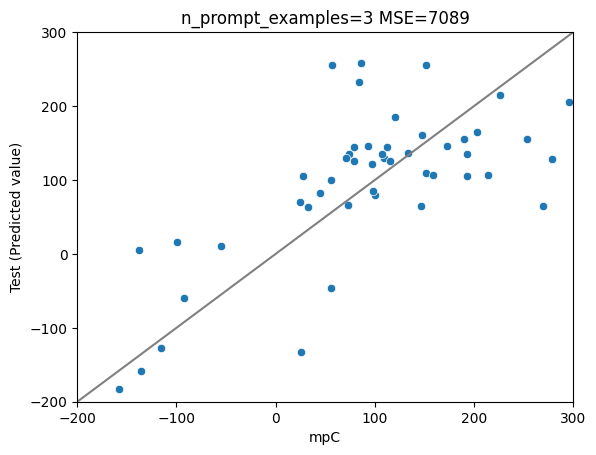

In [19]:
#plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from datetime import datetime
import json
current_datetime = datetime.now()
vmin=-200
vmax=300

#plot prediction results
for n_prompt_examples,records in prediction_results.items():
    sel_df=pd.DataFrame(records)
    #floatに可能なものは変換
    sel_df["Test (Predicted value)"] = pd.to_numeric(sel_df["Test (Predicted value)"], errors='coerce')
    sel_df=sel_df[sel_df["Test (Predicted value)"].notnull()]
    if len(sel_df)==0:
        continue
    mse=mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"])

    plt.figure()
    sns.scatterplot(data=sel_df,x="mpC",y="Test (Predicted value)")
    plt.title(f"n_prompt_examples={n_prompt_examples} MSE={mse:.0f}")

    #x,yの範囲を揃える
    plt.xlim(vmin,vmax)
    plt.ylim(vmin,vmax)
    #対角線を描く
    plt.plot([vmin,vmax],[vmin,vmax],color="gray")
    formatted_filename = f"results/model={model_size}_{current_datetime.strftime('%Y%m%d_%H%M%S')}_train={do_train}.png"
    plt.savefig(formatted_filename)
    #break

save_json_filename=formatted_filename.replace(".png",".json")
with open(save_json_filename,"w") as f:
    json.dump(prediction_results,fp=f,
              indent=4)

In [20]:
#スコア
print(mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print(mean_absolute_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print(r2_score(sel_df["mpC"],sel_df["Test (Predicted value)"]))


7088.903399999999
65.778
0.381102375321117


In [21]:
#回答可能な問題の割合
sel_df.shape[0]/n_test

1.0